<a href="https://colab.research.google.com/github/yongtaoliu/Physics--cVAE/blob/main/Notebook2_2DCards_Physics_%3EVAE_cont_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditioning VAE on a continuous "property" vector

Notes:


March, 2022

- Analyses by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118) using $Pyroved$ developed by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)
- [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)

Package Version:


*   pyroved: 0.2.3
*   numpy: 1.21.5
*   torch: 1.10.0+cu111

# **Install Pyroved**

In [ ]:
# !pip install git+https://github.com/ziatdinovmax/pyroved
!pip install pyroved
!pip install -q pyroved kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 36.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.3.4-cp310-cp310-linux_x86_64.whl size=11772939 sha256=1f98aac3351ce0e2cd9b8b7979a3623e5258f1f2c8c055d1ed3b928c04b0e590
  Stored in directory: /root/.cache/pip/wheels/38/c6/49/eaba6d234887d98d9c85185e2a90bd7bb77934e85eefaf317e
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 6.3 MB/s eta 0:00:00


# **Imports:**

In [ ]:
import pyroved as pv
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch.nn as nn
import kornia as K
tt = torch.tensor

## **Download Card Images**

In [ ]:
!gdown https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip cards.zip

Downloading...
From: https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
To: /content/cards.zip
100% 30.2k/30.2k [00:00<00:00, 82.3MB/s]
Archive:  cards.zip
   creating: cards/
  inflating: cards/card4.JPG         
  inflating: cards/card1.JPG         
  inflating: cards/card2.JPG         
  inflating: cards/card3.JPG         


Load data into the notebook and transform to a proper format:

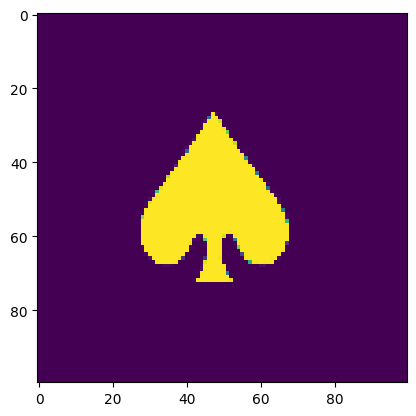

In [ ]:
# You can easily load the same file here in all 4 card groups
# E.g. use cards3 for hearts

rs = lambda x: cv2.resize(x, (100, 100), cv2.INTER_CUBIC)
card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
card1 = tt(1 - card1 / card1.max())
card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
card2 = tt(1 - card2 / card2.max())
card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
card3 = tt(1 - card3 / card3.max())
card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
card4 = tt(1 - card4 / card4.max())
plt.imshow(card2)

Prepare training dataset by adding rotation, shift to the card images

In [ ]:
def affine_transform(imgdata: torch.Tensor,
                     angle: torch.Tensor = None,
                     shift: torch.Tensor = None,
                     shear: torch.Tensor = None) -> torch.Tensor:                
    imgdata = imgdata[:,:,10:90, 10:90]
    if angle is not None:
        imgdata = K.geometry.rotate(imgdata, angle)
    if shear is not None:
        imgdata = K.geometry.shear(imgdata, shear)
    if shift is not None:
        imgdata = K.geometry.translate(imgdata, shift)
    return imgdata

batch_size = 1000

cards1 = card1[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards1 = cards1.to(torch.float32)
theta1 = torch.distributions.Uniform(0, 30).sample((batch_size,))
shift1 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear1 = torch.distributions.Normal(0, .00002).sample((batch_size, 2))
cards1_transformed = affine_transform(cards1, theta1, shift1, shear1)

cards2 = card2[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards2 = cards2.to(torch.float32)
theta2 = torch.distributions.Uniform(0, 30).sample((batch_size,))
shift2 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear2 = torch.distributions.Normal(0, .002).sample((batch_size, 2))
cards2_transformed = affine_transform(cards2, theta2, shift2, shear2)

cards3 = card3[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards3 = cards3.to(torch.float32)
theta3 = torch.distributions.Uniform(0, 30).sample((batch_size,))
shift3 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear3 = torch.distributions.Normal(0, .002).sample((batch_size, 2))
cards3_transformed = affine_transform(cards3, theta3, shift3, shear3)

cards4 = card4[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards4 = cards4.to(torch.float32)
theta4 = torch.distributions.Uniform(0, 30).sample((batch_size,))
shift4 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear4 = torch.distributions.Normal(0, .002).sample((batch_size, 2))
cards4_transformed = affine_transform(cards4, theta4, shift4, shear4)

# Concatenate (this is our training set)
cards_all = torch.cat([cards1_transformed, cards2_transformed, cards3_transformed, cards4_transformed]).squeeze().float()
theta_all = torch.cat([theta1, theta2, theta3, theta4]).squeeze().float()
shift_all = torch.cat([shift1, shift2, shift3, shift4]).squeeze().float()
shear_all = torch.cat([shear1, shear2, shear3, shear4]).squeeze().float()

index_array = np.concatenate([np.zeros(cards1.shape[0]), 
                              np.zeros(cards2.shape[0])+1, 
                              np.zeros(cards3.shape[0])+2, 
                              np.zeros(cards4.shape[0])+3]
                             )

cards_all = cards_all + 0.01 * torch.randn(size=(4000,80,80))

Plot training dataset

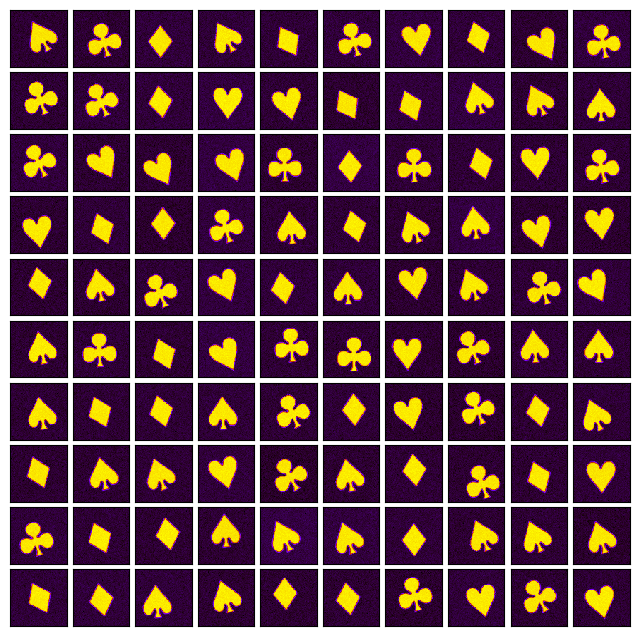

In [ ]:
np.random.seed(1)
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all))
    ax.imshow(cards_all[i], cmap='gnuplot', interpolation='nearest')

Prepare training data

In [ ]:
train_data = cards_all 
translation_x_, translation_y_ = shift_all[:,0].unsqueeze(1), shift_all[:,1].unsqueeze(1)
rotate_ = theta_all.unsqueeze(1)
shear_x_, shear_y_ = shear_all[:,0].unsqueeze(1), shear_all[:,1].unsqueeze(1)

In [ ]:
#training steps
steps = 200

## Let us do simple VAE analysis 

In [ ]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

in_dim = (80, 80)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae0 = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae0)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1949.7122
Epoch: 2 Training loss: 1211.5020
Epoch: 3 Training loss: 1200.8243
Epoch: 4 Training loss: 1182.2790
Epoch: 5 Training loss: 1155.1557
Epoch: 6 Training loss: 1122.5226
Epoch: 7 Training loss: 1084.2721
Epoch: 8 Training loss: 1029.5890
Epoch: 9 Training loss: 965.5958
Epoch: 10 Training loss: 921.0233
Epoch: 11 Training loss: 880.7789
Epoch: 12 Training loss: 845.7485
Epoch: 13 Training loss: 810.8582
Epoch: 14 Training loss: 779.7493
Epoch: 15 Training loss: 755.3002
Epoch: 16 Training loss: 732.6284
Epoch: 17 Training loss: 716.1295
Epoch: 18 Training loss: 701.1599
Epoch: 19 Training loss: 688.4073
Epoch: 20 Training loss: 676.8104
Epoch: 21 Training loss: 667.5206
Epoch: 22 Training loss: 656.9595
Epoch: 23 Training loss: 648.9999
Epoch: 24 Training loss: 640.9804
Epoch: 25 Training loss: 635.4658
Epoch: 26 Training loss: 627.9858
Epoch: 27 Training loss: 624.5668
Epoch: 28 Training loss: 615.3937
Epoch: 29 Training loss: 610.5003
Epoch: 30 Train

Encode the training data into the latent space:

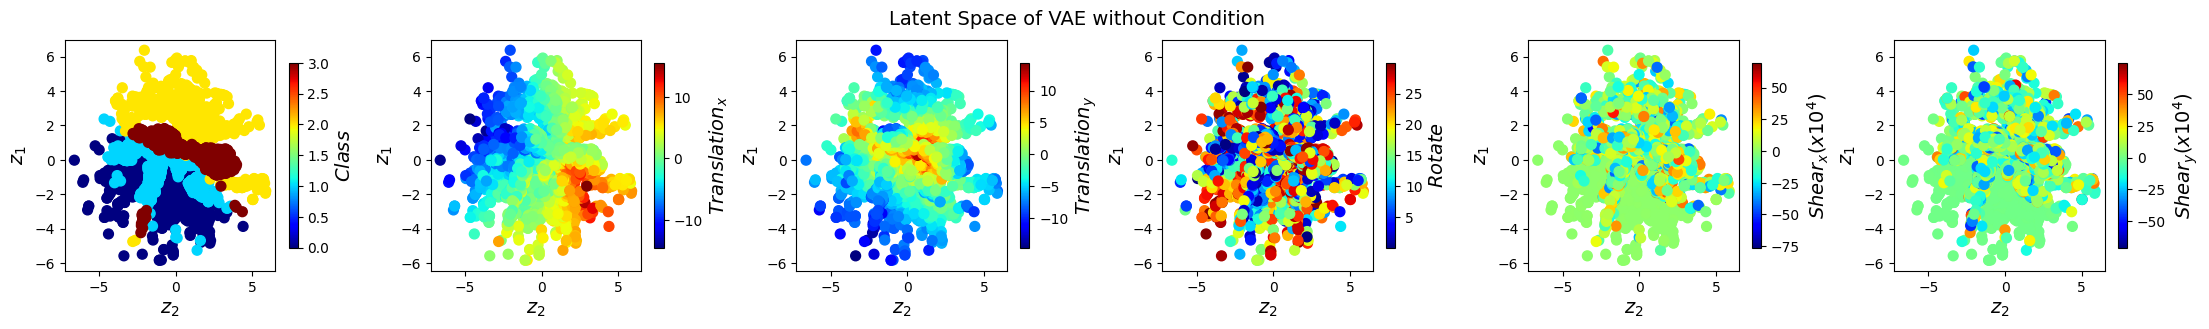

In [ ]:
z_mean, z_sd = vae0.encode(train_data)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of VAE without Condition", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)


Plot latent variables vs ground truth

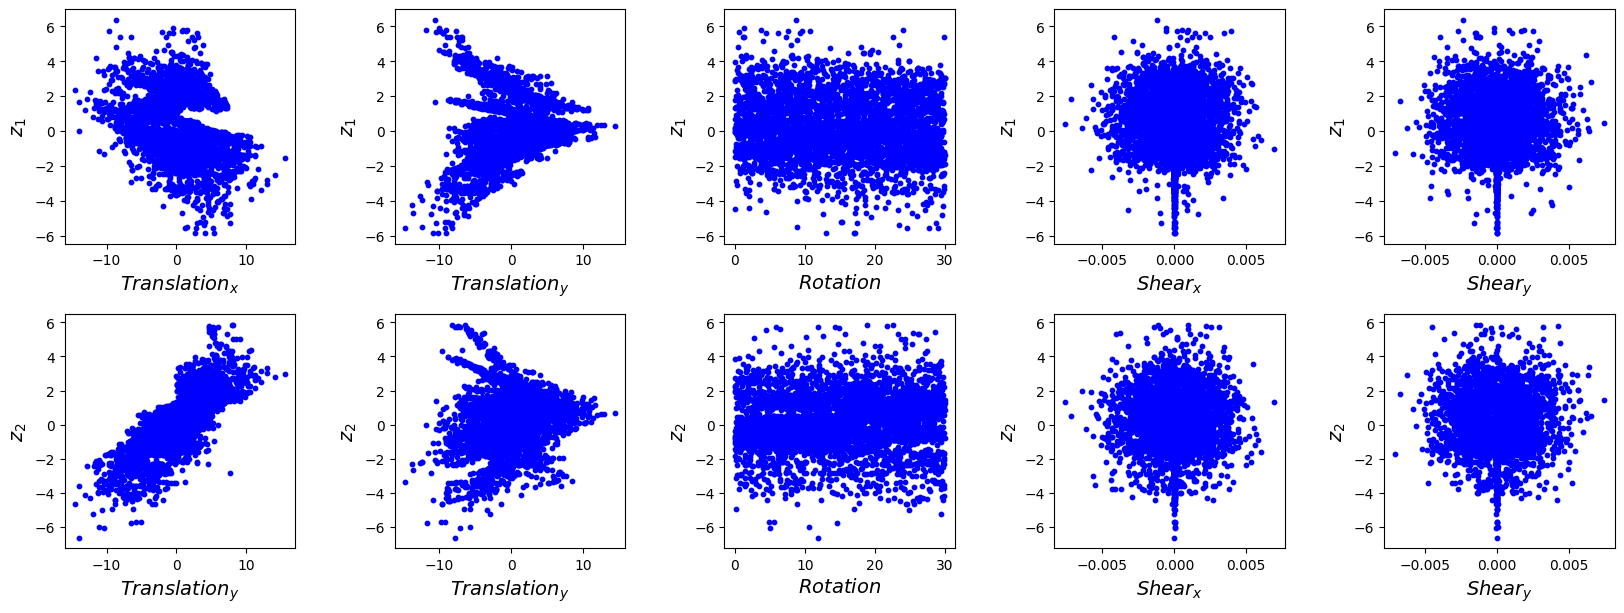

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = 'b', s = 10)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);

## Train VAE model where our prior is conditioned on a continuous vector $c$ as $p(z|c)$. Here we pass the information about rotation as our $c$ vector.

In [ ]:
in_dim = (80, 80)
vae1 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, invariances=None, seed=0)
vae1

iVAE(
  (encoder_z): fcEncoderNet(
    (concat): Concat()
    (fc_layers): Sequential(
      (0): Linear(in_features=6400, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (fc11): Linear(in_features=128, out_features=2, bias=True)
    (fc12): Linear(in_features=128, out_features=2, bias=True)
    (activation_out): Softplus(beta=1, threshold=20)
  )
  (decoder): fcDecoderNet(
    (concat): Concat()
    (fc_layers): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (out): Linear(in_features=128, out_features=6400, bias=True)
    (activation_out): Sigmoid()
  )
)

In [ ]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), rotate_, batch_size=64)

in_dim = (80, 80)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae1 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae1)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1858.0589
Epoch: 2 Training loss: 1212.3043
Epoch: 3 Training loss: 1202.0412
Epoch: 4 Training loss: 1197.9494
Epoch: 5 Training loss: 1195.9480
Epoch: 6 Training loss: 1196.5490
Epoch: 7 Training loss: 1196.5889
Epoch: 8 Training loss: 1195.0432
Epoch: 9 Training loss: 1192.8378
Epoch: 10 Training loss: 1192.3689
Epoch: 11 Training loss: 1194.5262
Epoch: 12 Training loss: 1195.2521
Epoch: 13 Training loss: 1192.4896
Epoch: 14 Training loss: 1190.0927
Epoch: 15 Training loss: 1188.5932
Epoch: 16 Training loss: 1180.1659
Epoch: 17 Training loss: 1153.9514
Epoch: 18 Training loss: 1124.1667
Epoch: 19 Training loss: 1102.2466
Epoch: 20 Training loss: 1085.8958
Epoch: 21 Training loss: 1073.7190
Epoch: 22 Training loss: 1064.5400
Epoch: 23 Training loss: 1057.2117
Epoch: 24 Training loss: 1048.9768
Epoch: 25 Training loss: 1041.1047
Epoch: 26 Training loss: 1030.6642
Epoch: 27 Training loss: 1018.5288
Epoch: 28 Training loss: 994.0313
Epoch: 29 Training loss: 921.9

Encode the training data into the latent space:

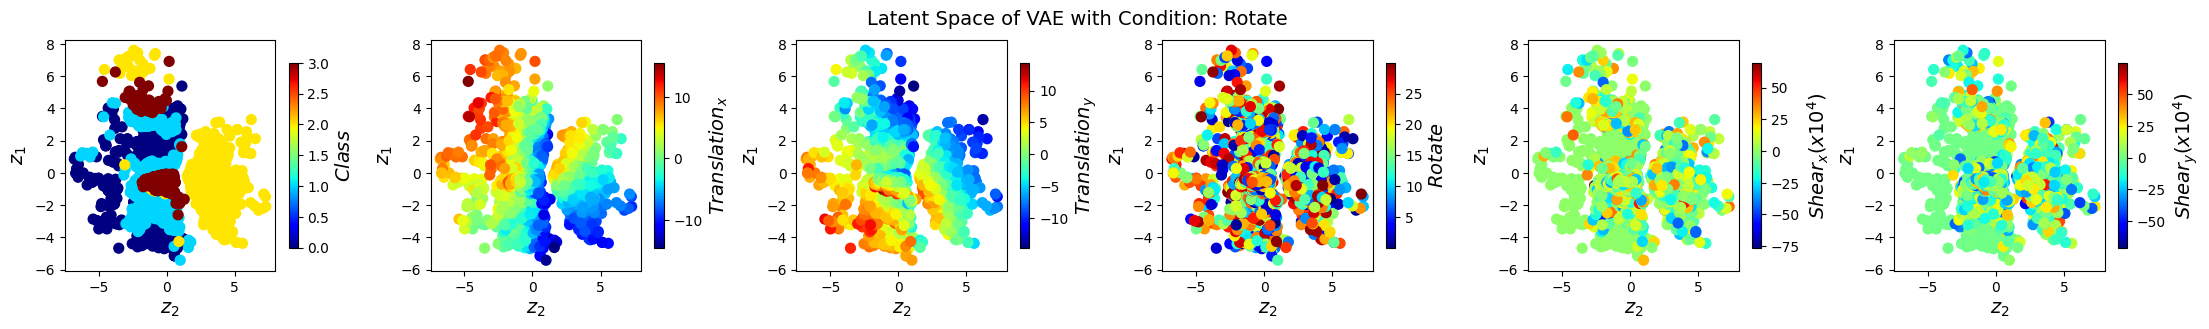

In [ ]:
z_mean, z_sd = vae1.encode(train_data)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of VAE with Condition: Rotate", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)

- Plot the learned latent manifolds conditioned on the parameter.
- Obviously, it makes sense to check parameter range first
- But it is also cool to check how/if it extrapolates

In [ ]:
print(translation_x_.min(), translation_x_.max())
print(rotate_.min(), rotate_.max())

tensor(-14.4919) tensor(15.5536)
tensor(0.0187) tensor(29.9819)


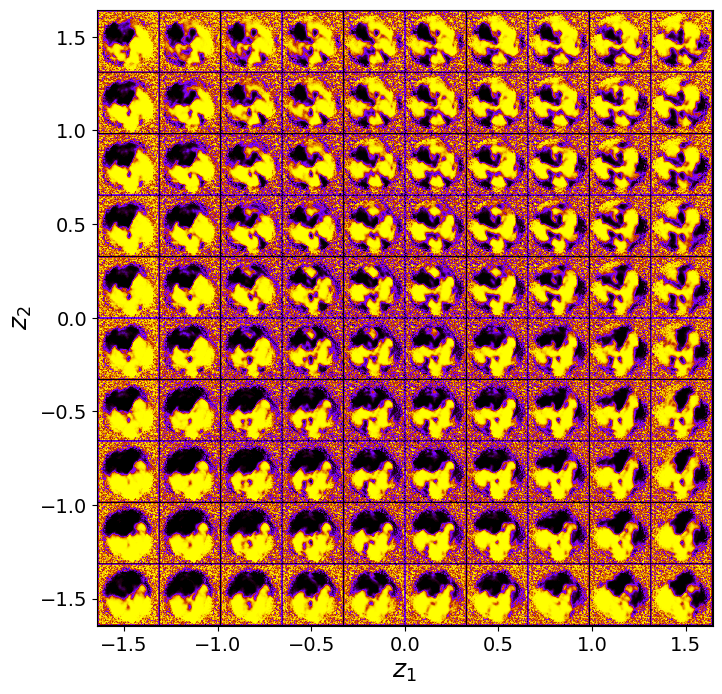

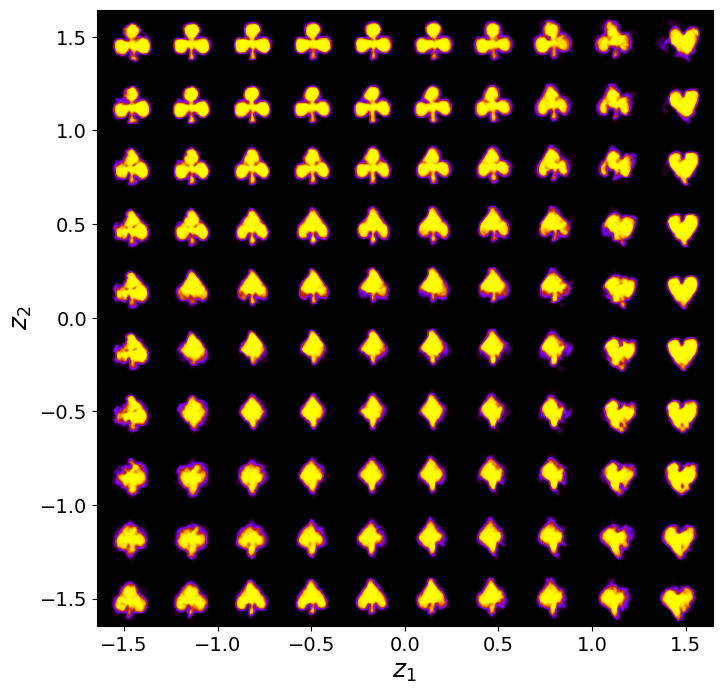

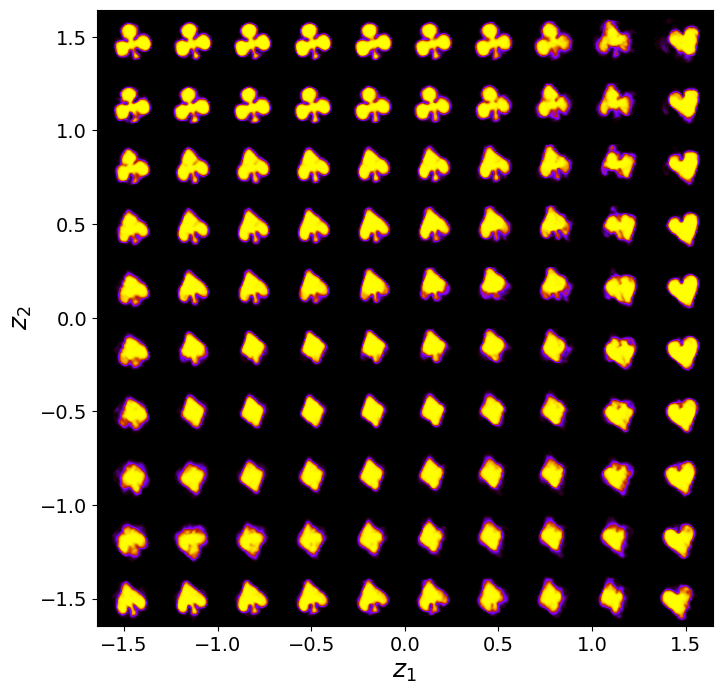

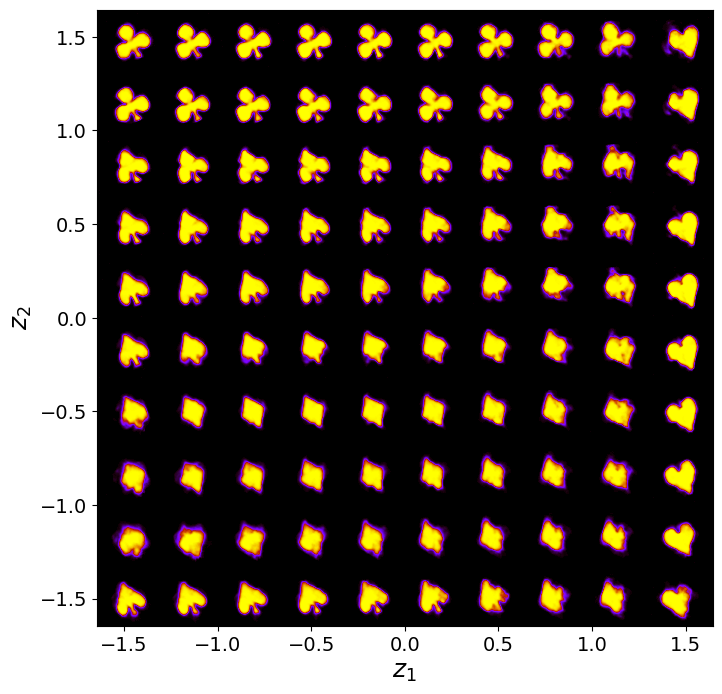

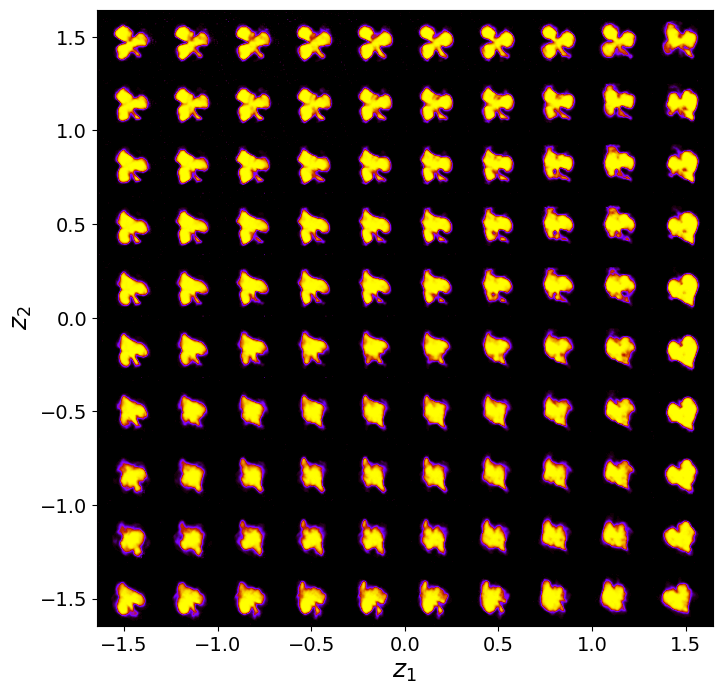

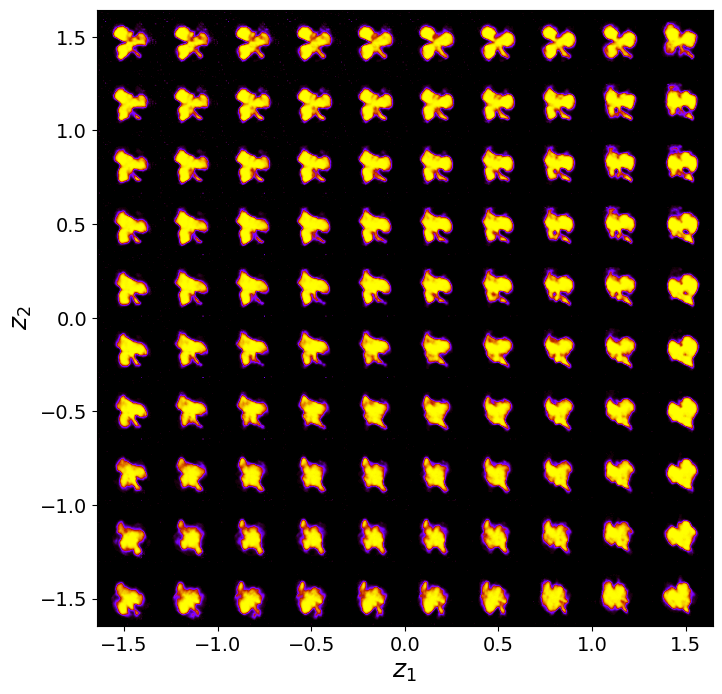

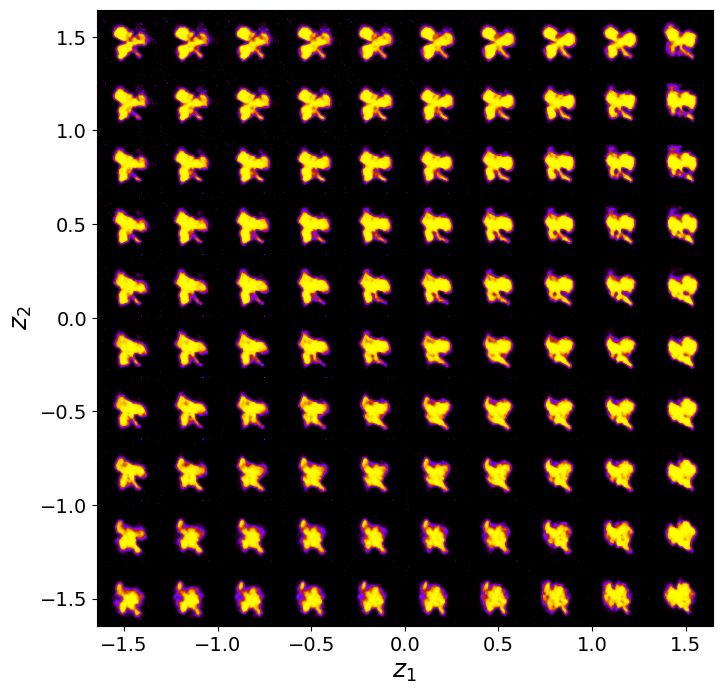

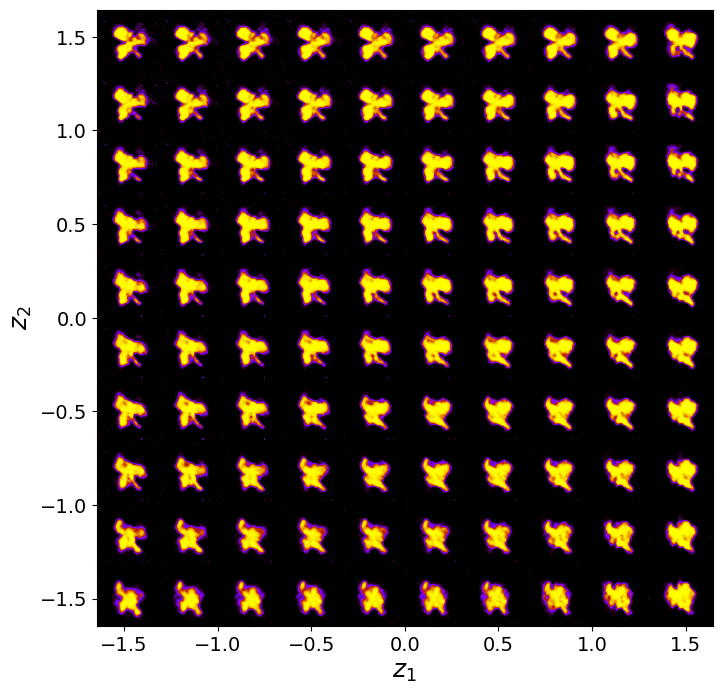

In [ ]:
y_all = [-15, 0, 15, 30, 45, 60, 75, 90]
for y in y_all:
    y = torch.tensor(y).unsqueeze(0)
    vae1.manifold2d(10, y)

Plot the latent variables vs. the ground truth:

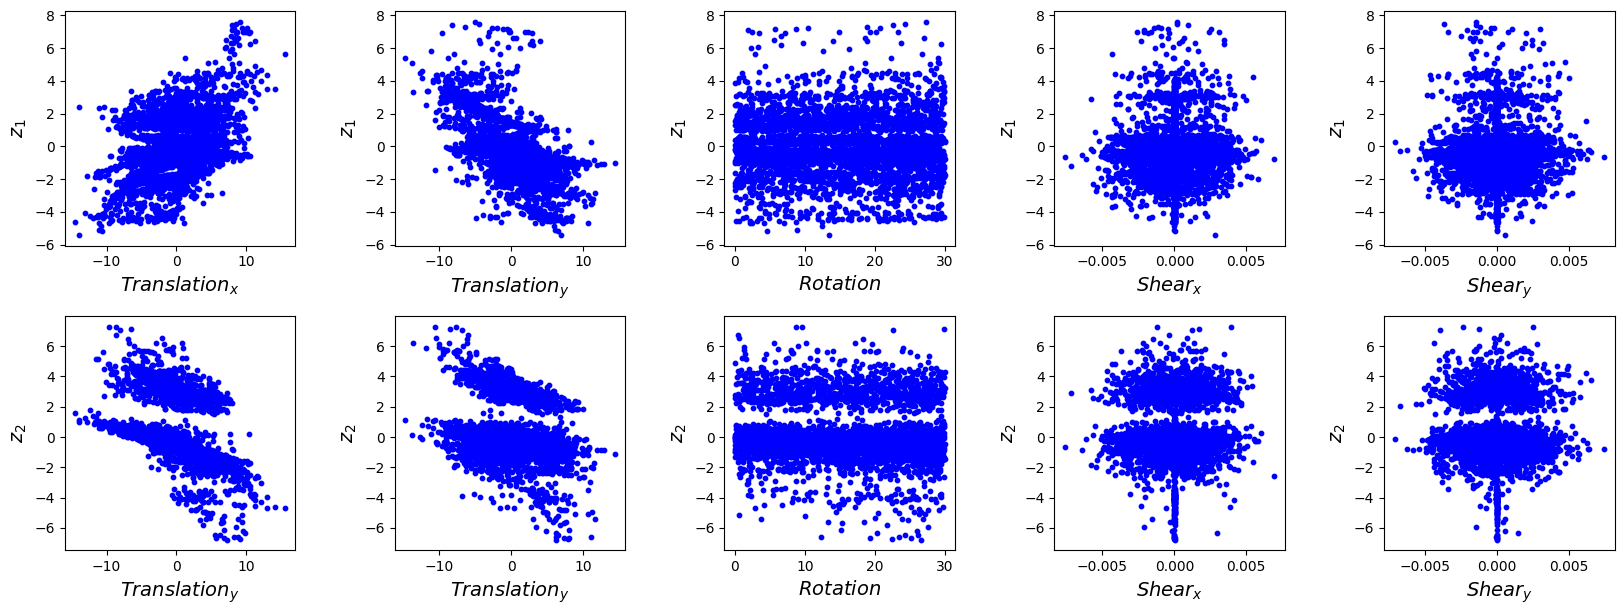

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = 'b', s = 10)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);

## Now let's condition on a 2-dimensional vector containing information on the translation_x and rotation.

In [ ]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(
    train_data.unsqueeze(1), torch.cat([translation_x_, rotate_], -1), batch_size=64)


# Initialize VAE (we specify c_dim=2 to add extra dimensions corresponding to c-vector to the decoder)
vae2 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=2, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae2)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1856.2685
Epoch: 2 Training loss: 1207.9608
Epoch: 3 Training loss: 1157.2984
Epoch: 4 Training loss: 1086.3331
Epoch: 5 Training loss: 1062.7164
Epoch: 6 Training loss: 1046.6366
Epoch: 7 Training loss: 1029.7440
Epoch: 8 Training loss: 991.9420
Epoch: 9 Training loss: 942.0270
Epoch: 10 Training loss: 909.0090
Epoch: 11 Training loss: 880.7754
Epoch: 12 Training loss: 857.2137
Epoch: 13 Training loss: 835.9880
Epoch: 14 Training loss: 802.8815
Epoch: 15 Training loss: 743.0902
Epoch: 16 Training loss: 695.2875
Epoch: 17 Training loss: 661.2883
Epoch: 18 Training loss: 632.3391
Epoch: 19 Training loss: 605.6346
Epoch: 20 Training loss: 581.5696
Epoch: 21 Training loss: 561.3003
Epoch: 22 Training loss: 542.6246
Epoch: 23 Training loss: 526.4687
Epoch: 24 Training loss: 510.7686
Epoch: 25 Training loss: 495.7189
Epoch: 26 Training loss: 483.3993
Epoch: 27 Training loss: 470.3294
Epoch: 28 Training loss: 458.8227
Epoch: 29 Training loss: 448.7888
Epoch: 30 Traini

In [ ]:
print(translation_x_.min(), translation_x_.max())
print(rotate_.min(), rotate_.max())

tensor(-14.4919) tensor(15.5536)
tensor(0.0187) tensor(29.9819)


tensor([-15]) tensor([60])


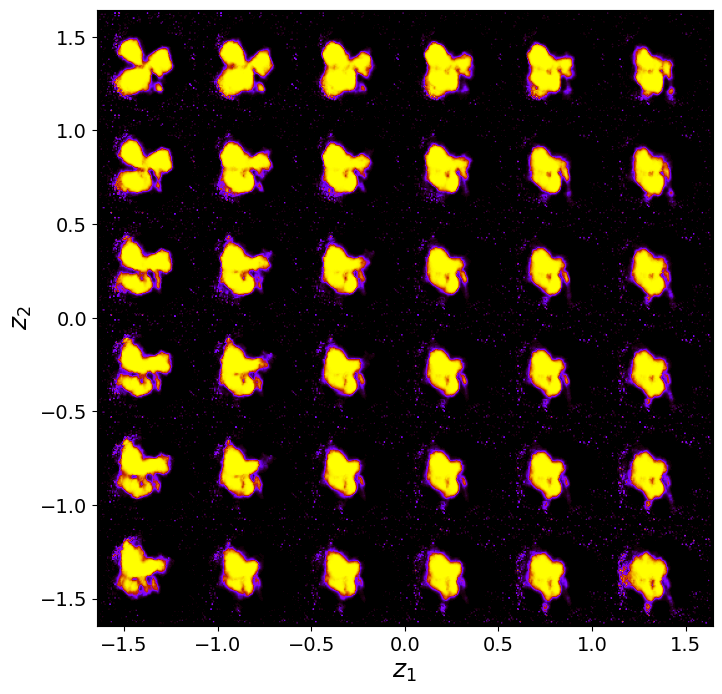

tensor([0]) tensor([60])


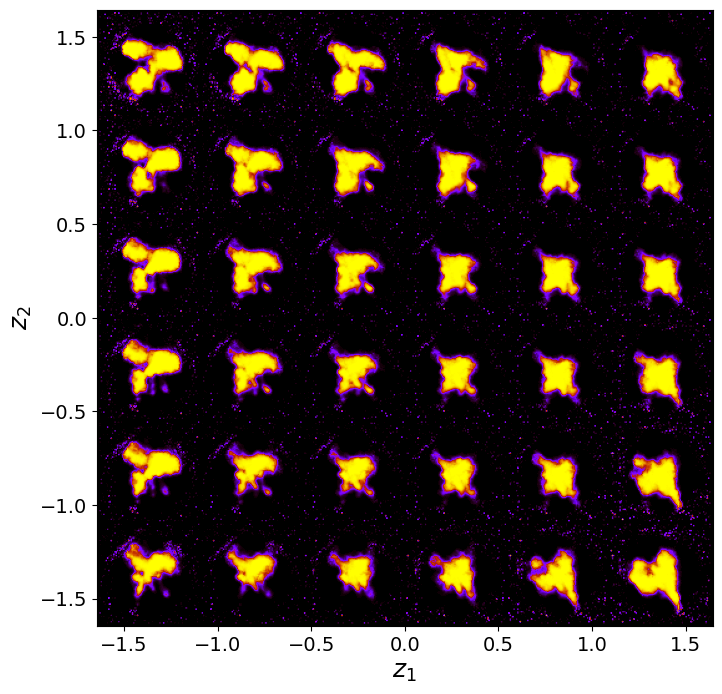

tensor([15]) tensor([60])


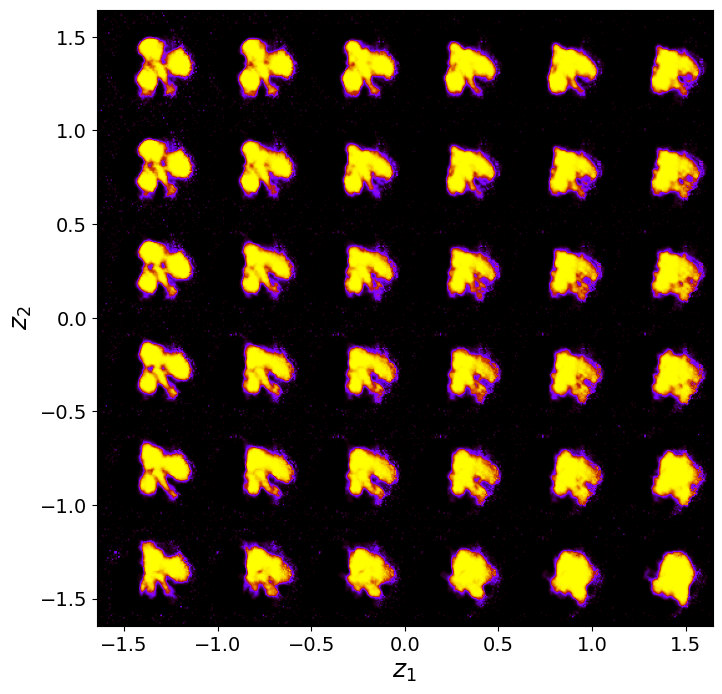

In [ ]:
# Play with the evolution 

y1_all = [-15, 0, 15]
y2_all = [60]
for y in y1_all:
    y1 = torch.tensor(y).unsqueeze(0)
    y2 = torch.tensor(y2_all)
    print(y1, y2)
    y = torch.cat([y1, y2], -1).unsqueeze(0)
    vae2.manifold2d(6, y)

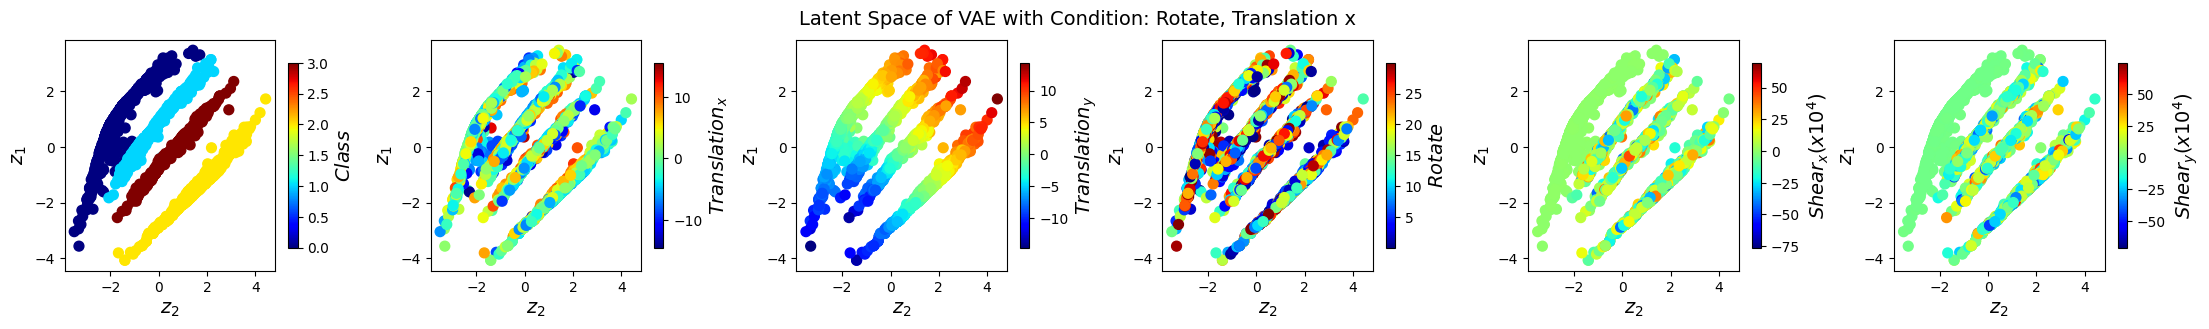

In [ ]:
### Encode the training data into the latent space:###

z_mean, z_sd = vae2.encode(train_data)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of VAE with Condition: Rotate, Translation x", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)

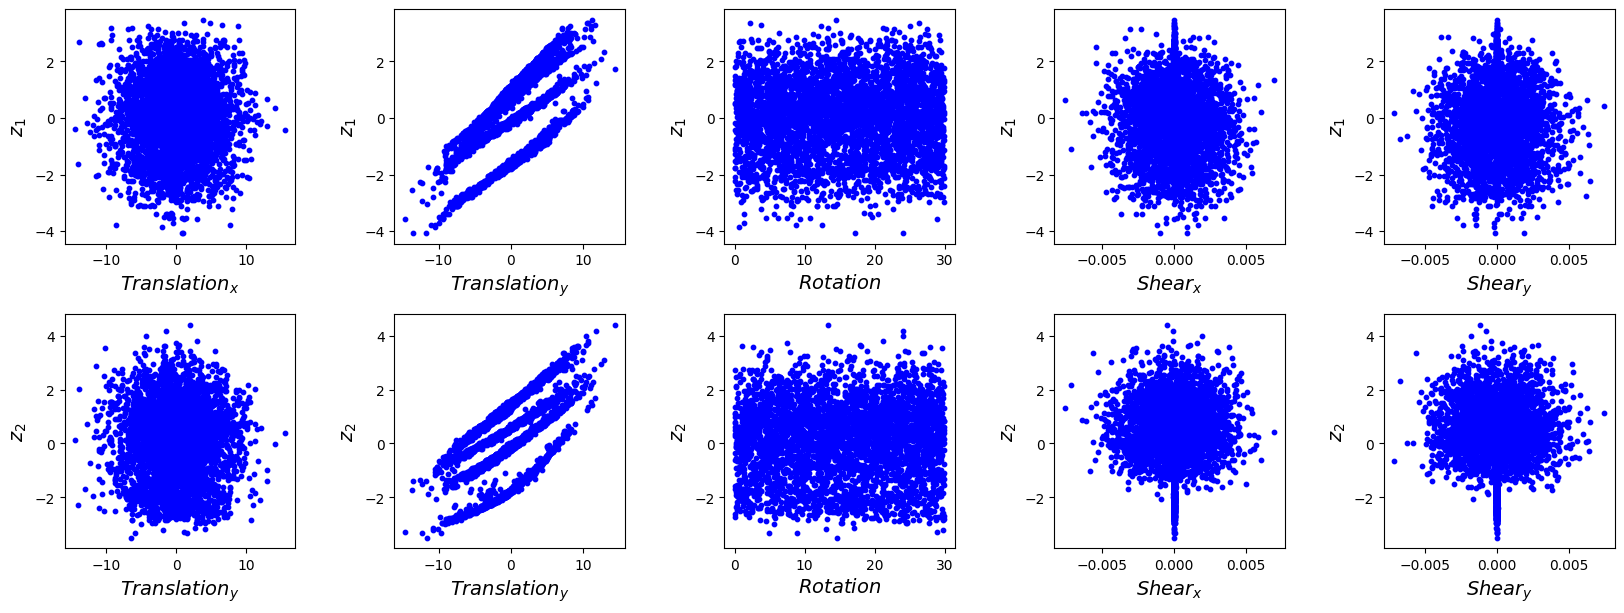

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = 'b', s = 10)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);

## Now let's condition on a 3-dimensional vector containing information on the translation_x, translation_y, rotation.

In [ ]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(
    train_data.unsqueeze(1), torch.cat([translation_x_, translation_y_, rotate_], -1), batch_size=64)


# Initialize VAE (we specify c_dim=2 to add extra dimensions corresponding to c-vector to the decoder)
vae3 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=3, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae3)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1870.6168
Epoch: 2 Training loss: 1175.7377
Epoch: 3 Training loss: 1094.8045
Epoch: 4 Training loss: 1010.7241
Epoch: 5 Training loss: 941.9251
Epoch: 6 Training loss: 891.4460
Epoch: 7 Training loss: 840.4101
Epoch: 8 Training loss: 793.3437
Epoch: 9 Training loss: 740.0458
Epoch: 10 Training loss: 685.2854
Epoch: 11 Training loss: 644.0788
Epoch: 12 Training loss: 609.6637
Epoch: 13 Training loss: 579.0295
Epoch: 14 Training loss: 551.6372
Epoch: 15 Training loss: 528.0758
Epoch: 16 Training loss: 506.5815
Epoch: 17 Training loss: 488.4228
Epoch: 18 Training loss: 471.3120
Epoch: 19 Training loss: 456.5538
Epoch: 20 Training loss: 443.1366
Epoch: 21 Training loss: 431.0435
Epoch: 22 Training loss: 419.3996
Epoch: 23 Training loss: 408.7381
Epoch: 24 Training loss: 399.4353
Epoch: 25 Training loss: 390.8542
Epoch: 26 Training loss: 382.6940
Epoch: 27 Training loss: 374.6018
Epoch: 28 Training loss: 368.1546
Epoch: 29 Training loss: 362.0518
Epoch: 30 Training 

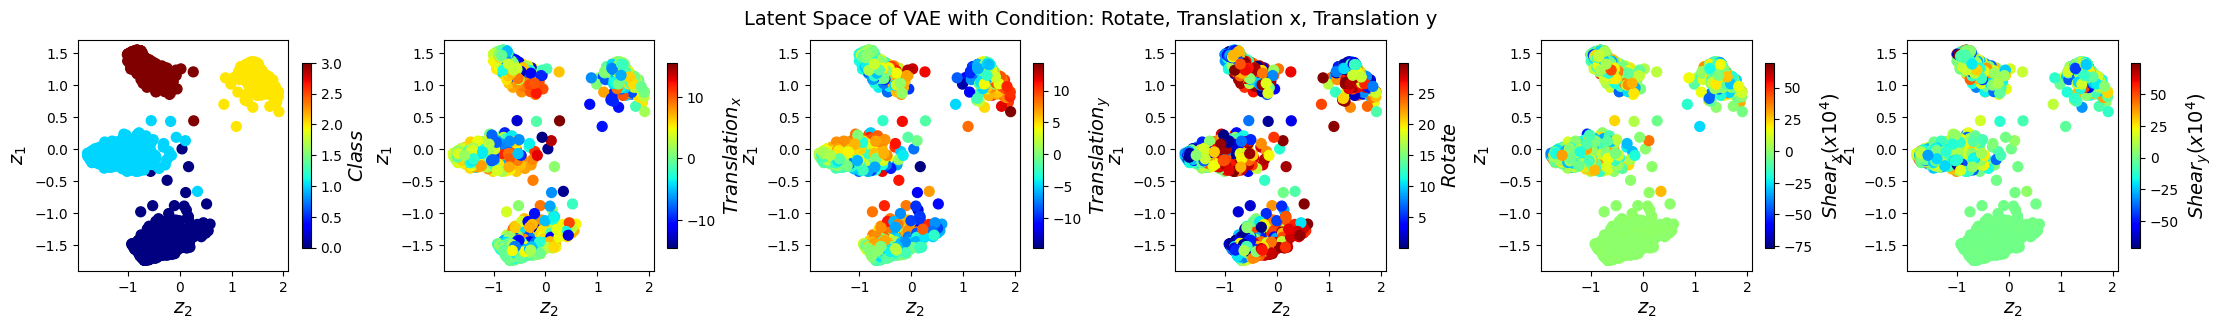

In [ ]:
### Encode the training data into the latent space:###

z_mean, z_sd = vae3.encode(train_data)


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of VAE with Condition: Rotate, Translation x, Translation y", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)

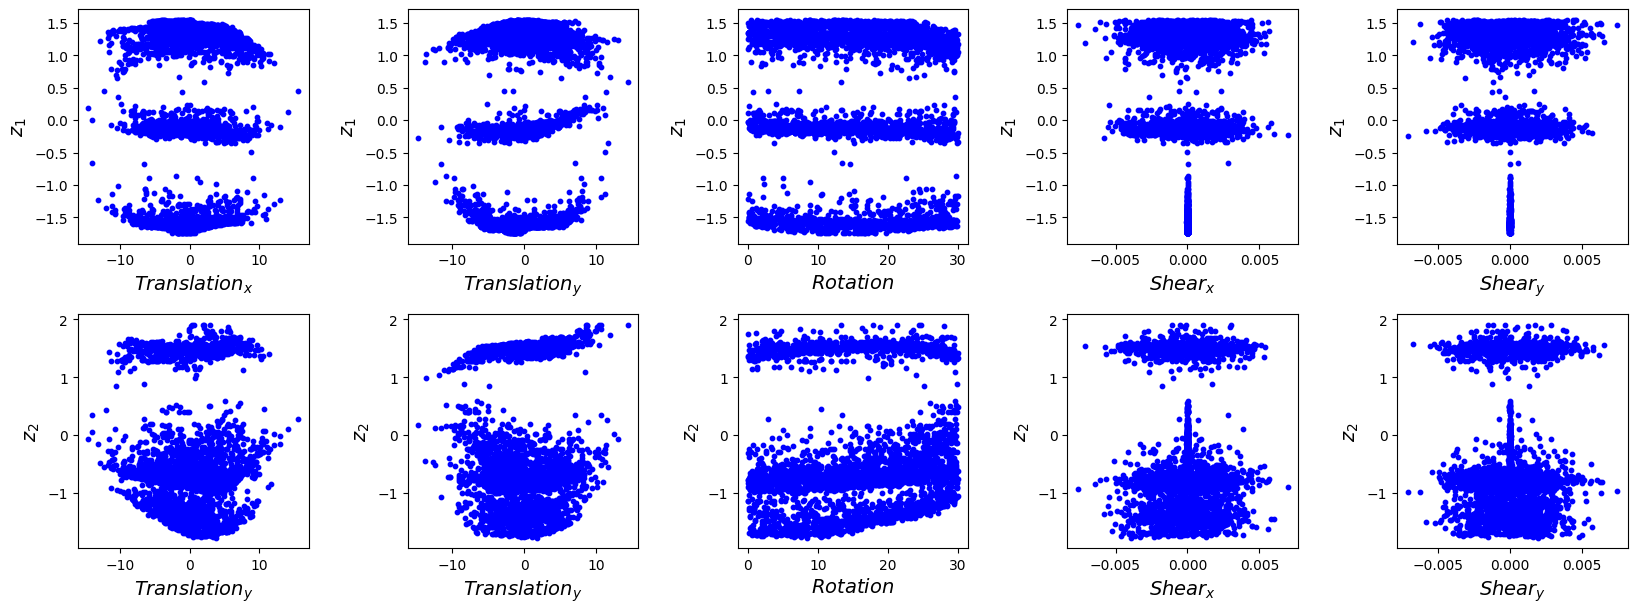

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = 'b', s = 10)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);

## Now let's condition on a 5-dimensional vector containing information on the translation_x, translation_y, rotation, sheer_x, sheer_y.

In [ ]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(
    train_data.unsqueeze(1), torch.cat([translation_x_, translation_y_, rotate_, shear_x_, shear_y_], -1), batch_size=64)


# Initialize VAE (we specify c_dim=2 to add extra dimensions corresponding to c-vector to the decoder)
vae5 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=5, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae5)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1853.0365
Epoch: 2 Training loss: 1193.0825
Epoch: 3 Training loss: 1146.4439
Epoch: 4 Training loss: 1063.3263
Epoch: 5 Training loss: 973.3796
Epoch: 6 Training loss: 919.4913
Epoch: 7 Training loss: 880.8884
Epoch: 8 Training loss: 827.5015
Epoch: 9 Training loss: 764.7869
Epoch: 10 Training loss: 719.0217
Epoch: 11 Training loss: 679.6309
Epoch: 12 Training loss: 642.5257
Epoch: 13 Training loss: 608.0768
Epoch: 14 Training loss: 578.8327
Epoch: 15 Training loss: 552.6857
Epoch: 16 Training loss: 529.8463
Epoch: 17 Training loss: 509.5813
Epoch: 18 Training loss: 491.2214
Epoch: 19 Training loss: 474.8346
Epoch: 20 Training loss: 460.3197
Epoch: 21 Training loss: 446.5031
Epoch: 22 Training loss: 434.4119
Epoch: 23 Training loss: 422.9469
Epoch: 24 Training loss: 412.9400
Epoch: 25 Training loss: 403.2063
Epoch: 26 Training loss: 394.1994
Epoch: 27 Training loss: 386.0362
Epoch: 28 Training loss: 377.6070
Epoch: 29 Training loss: 370.5661
Epoch: 30 Training 

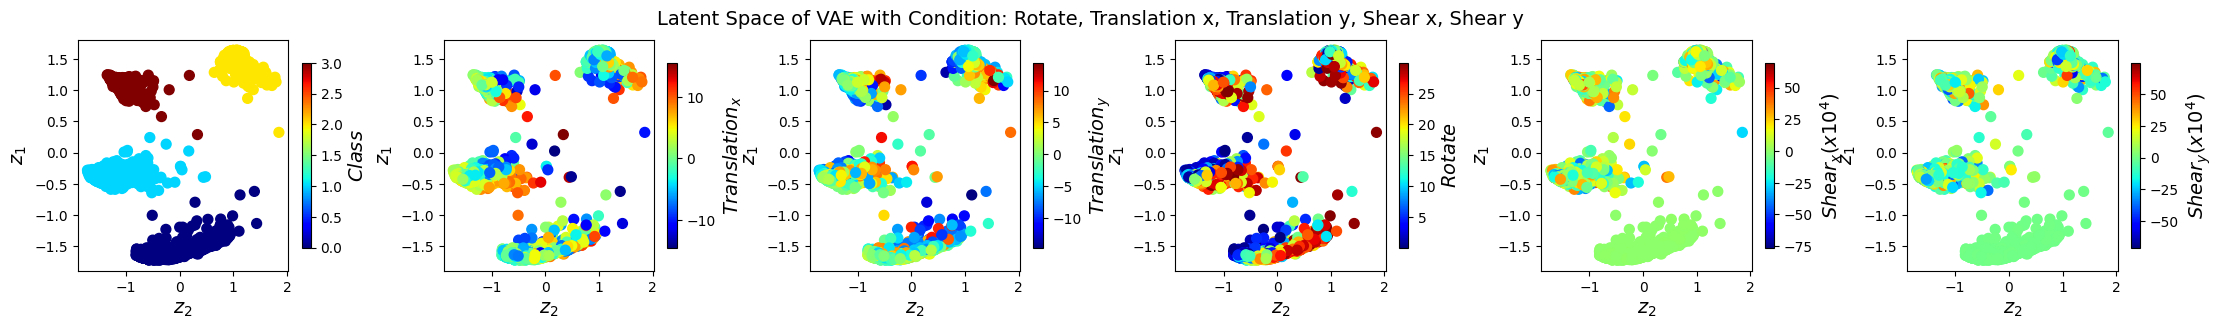

In [ ]:
### Encode the training data into the latent space:###

z_mean, z_sd = vae5.encode(train_data)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of VAE with Condition: Rotate, Translation x, Translation y, Shear x, Shear y", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)

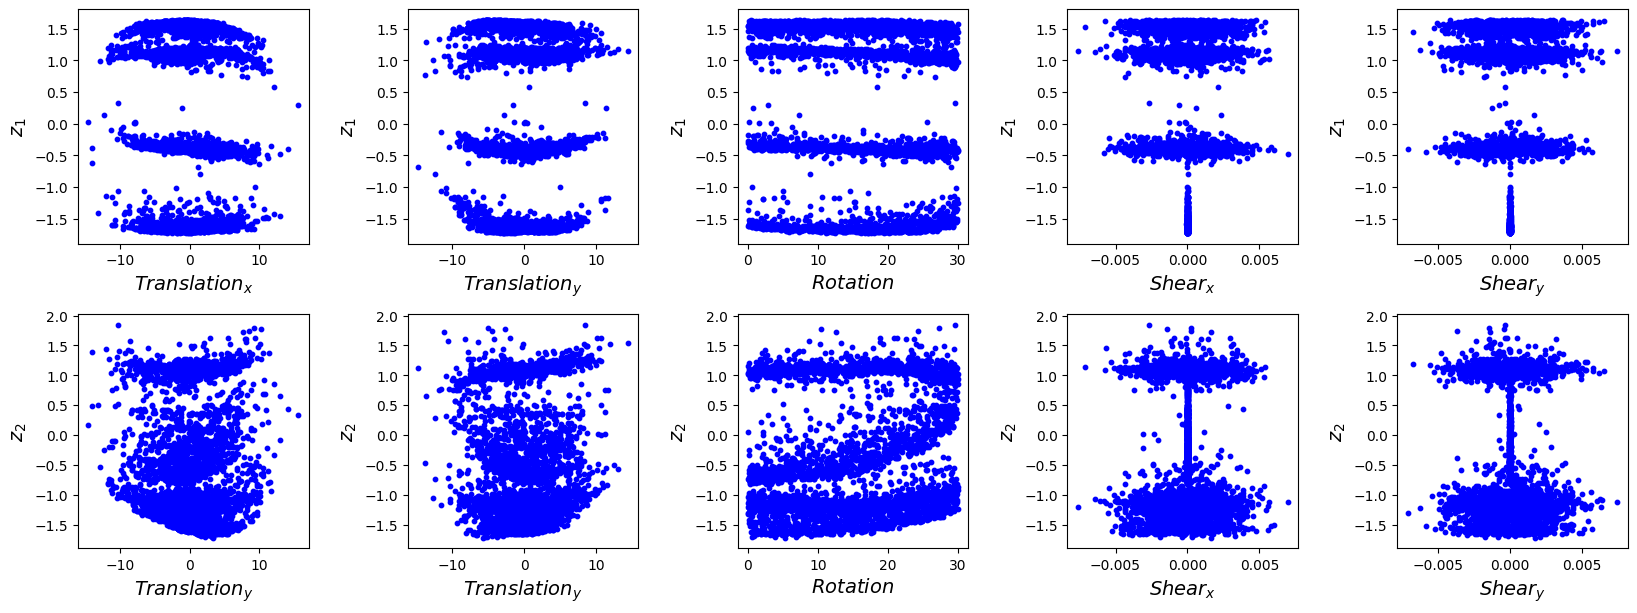

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = 'b', s = 10)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);